In [46]:
print('ping')

ping


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import visualization
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import sys
import os
import glob

import utils

In [48]:
D_PayneDir = utils.D_PayneDir
Standards_Dir = D_PayneDir+'other_data/standards/'

In [49]:
def find_obj_in_sample(Obj_RA_Dec, Sample_RA_Dec, sep=0.0001*u.deg, nsteps=10, verbose=True):
    coord = Obj_RA_Dec
    for i in range(nsteps):
        match_ind = np.argwhere(Sample_RA_Dec.separation(coord) < sep)
        if len(match_ind) < 1:
            sep = sep * 1.1
        elif len(match_ind) > 1:
            sep = sep * 0.9
        elif len(match_ind) == 1:
            continue
    if len(match_ind) < 1:
        if verbose:
            print('No Matches within %.2e degrees' % sep.value)
        return()
    elif len(match_ind) > 1:
        if verbose:
            print('Multiple Matches within %.2e' % sep.value)
        return(match_ind)
    else:
        if verbose:
            print('MATCH FOUND!')
        match_ind = match_ind[0,0]
        match_sep = Sample_RA_Dec[match_ind].separation(coord).deg
        return(match_ind, match_sep)
    
def restore_observed_spectra(target, method):
    SpectraFile = target + '_' + method + '.npz'
    temp = np.load(SpectraDir + SpectraFile)
    obj = temp['obj']
    norm_spec = temp['norm_spec']
    spectral_err = temp['spec_err']
    dv = temp['dv']
    Obs_RA_Dec = SkyCoord(temp['RA_Dec'])
    temp.close()
    return(obj, norm_spec, spectral_err, dv, Obs_RA_Dec)

def restore_APOGEE_standards():
    temp = np.genfromtxt(Standards_Dir + 'APOGEEPayne_standards.txt', dtype=str)
    APOGEE_ID = temp[:,1]
    APOGEE_RA_Dec = SkyCoord([temp[i,1]+' '+temp[i,2] for i in range(len(temp))], unit=u.deg)
    Teff = temp[:,3]
    Logg = temp[:,4]
    MgH = temp[:,9]
    FeH = temp[:,18]
    Quality = temp[:,-1]
    return(APOGEE_ID, APOGEE_RA_Dec, Teff, Logg, MgH, FeH, Quality)

def restore_Kirby2010_standards(res='medium'):
    fname = Standards_Dir + 'Kirby2010_standards.txt'
    with open(fname) as f:
        temp = f.readlines()
    temp = temp[49:]
    temp = [x.strip() for x in temp]
    f.close()
    
    System = np.array([x[:15].replace(" ","") for x in temp])
    Name = np.array([x[15:29].replace(" ","") for x in temp])
    Ref = np.array([x[29:55].replace(" ","") for x in temp])
    RA = [x[55:66].strip().replace(" ",":") for x in temp]
    Dec = [x[66:78].strip().replace(" ",":") for x in temp]
    kirby_RA_Dec = SkyCoord(RA, Dec, unit=(u.hourangle,u.deg))
    
    if res == 'high':
        Teff = np.array([x[78:83].strip().replace(" ","") for x in temp],dtype=float)
        logg = np.array([x[83:88].strip().replace(" ","") for x in temp],dtype=float)
        Fe_H = np.array([x[93:99].strip().replace(" ","") for x in temp],dtype=float)
        Mg_Fe_temp = [x[104:110].strip().replace(" ","") for x in temp]
        Mg_Fe = np.array(['100' if x=='' else x for x in Mg_Fe_temp],dtype=float)
        Mg_Fe[Mg_Fe == 100] = np.nan
        Si_Fe_temp = [x[115:121].strip().replace(" ","") for x in temp]
        Si_Fe = np.array(['100' if x=='' else x for x in Si_Fe_temp],dtype=float)
        Si_Fe[Si_Fe == 100] = np.nan
        Ca_Fe_temp = [x[126:132].strip().replace(" ","") for x in temp]
        Ca_Fe = np.array(['100' if x=='' else x for x in Ca_Fe_temp],dtype=float)
        Ca_Fe[Ca_Fe == 100] = np.nan
        Ti_Fe_temp = [x[137:143].strip().replace(" ","") for x in temp]
        Ti_Fe = np.array(['100' if x=='' else x for x in Ti_Fe_temp],dtype=float)
        Ti_Fe[Ti_Fe == 100] = np.nan
    
    if res == 'medium':
        Teff = np.array([x[148:153].strip().replace(" ","") for x in temp],dtype=float)
        logg = np.array([x[153:158].strip().replace(" ","") for x in temp],dtype=float)
        Fe_H = np.array([x[163:169].strip().replace(" ","") for x in temp],dtype=float)
        Mg_Fe_temp = [x[174:180].strip().replace(" ","") for x in temp]
        Mg_Fe = np.array(['100' if x=='' else x for x in Mg_Fe_temp],dtype=float)
        Mg_Fe[Mg_Fe == 100] = np.nan
        Si_Fe_temp = [x[185:191].strip().replace(" ","") for x in temp]
        Si_Fe = np.array(['100' if x=='' else x for x in Si_Fe_temp],dtype=float)
        Si_Fe[Si_Fe == 100] = np.nan
        Ca_Fe_temp = [x[196:202].strip().replace(" ","") for x in temp]
        Ca_Fe = np.array(['100' if x=='' else x for x in Ca_Fe_temp],dtype=float)
        Ca_Fe[Ca_Fe == 100] = np.nan
        Ti_Fe_temp = [x[207:213].strip().replace(" ","") for x in temp]
        Ti_Fe = np.array(['100' if x=='' else x for x in Ti_Fe_temp],dtype=float)
        Ti_Fe[Ti_Fe == 100] = np.nan
        
    return(kirby_RA_Dec, System, Name, Teff, logg, Fe_H, Mg_Fe, Si_Fe, Ca_Fe, Ti_Fe)


def restore_Kirby2008_standards():
    fname = Standards_Dir + 'Kirby2008_standards.fit'
    hdul = fits.open(fname)
    
    RA = hdul[1].data['_RAJ2000']
    Dec = hdul[1].data['_DEJ2000']
    RA_Dec = SkyCoord(RA, Dec, unit=(u.deg,u.deg))
    cluster = hdul[1].data['Cluster']
    Teff = hdul[1].data['Teff']
    logg = hdul[1].data['log_g_']    
    FeH_M = hdul[1].data['__Fe_H_M']
    alphaFe_M = hdul[1].data['__a_Fe_M']
    FeH_H = hdul[1].data['__Fe_H_H']
    alphaFe_H = hdul[1].data['__a_Fe_H']
    
    return(RA_Dec, cluster, Teff, logg, FeH_M, alphaFe_M, FeH_H, alphaFe_H)

# Restore Observations

In [50]:
SpectraDir = D_PayneDir + 'spectra/obs_spectra/'
targets = ['m13', 'm15','m71', 'ngc2419', 'ngc7006',
           'pegdig', 'pegdig24', 'pegdig26']
# m2 & WLM have weird coordinates ex: RA 21:33:9.03 Dec +00:**:16.5

method = 'Horne'
verbose = False

# Restore APOGEE standards
APOGEE_ID, APOGEE_RA_Dec, APOGEE_Teff, APOGEE_logg,\
    APOGEE_MgH, APOGEE_FeH, APOGEE_Quality = restore_APOGEE_standards()
# Restore Kirby+ 2008 standards 
kirby_RA_Dec, kirby_cluster, kirby_Teff, kirby_logg,\
    kirby_FeH_M, kirby_alphaFe_M, kirby_FeH_H, kirby_alphaFe_H\
    = restore_Kirby2008_standards()

# Check APOGEE Payne Sample



APOGEE SUMMARY: m13
No Matches :(


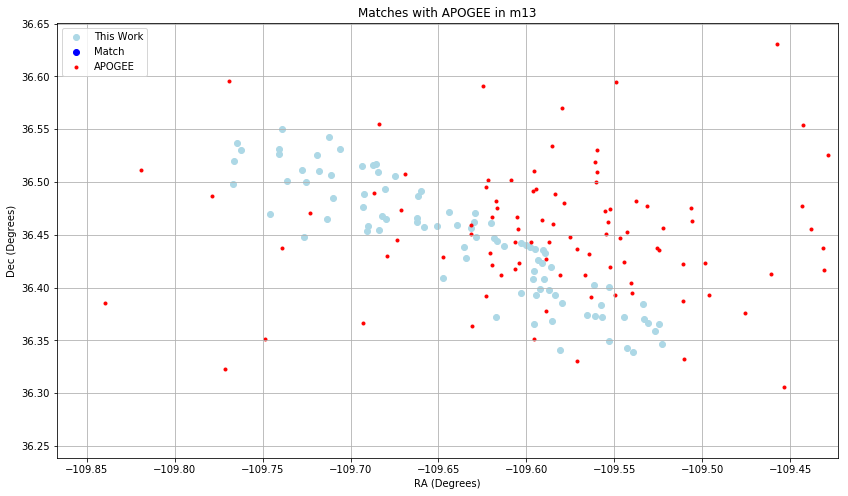



APOGEE SUMMARY: m15
2 Matches found
Index: 210253
Object: #008.0010337
DEIMOS Index: 8
DEIMOS Star Coordinate
RA: -37.505208 deg
Dec: 12.291389 deg
APOGEE Star Coordinate
RA: -37.505210 deg
Dec: 12.291350 deg
Teff = 5663.6 K
Logg = 4.30
[Fe/H] = 0.33
[Mg/H] = 0.23

Index: 210111
Object: #020.0010068
DEIMOS Index: 26
DEIMOS Star Coordinate
RA: -37.634292 deg
Dec: 12.255278 deg
APOGEE Star Coordinate
RA: -37.634370 deg
Dec: 12.255250 deg
Teff = 5650.5 K
Logg = 3.64
[Fe/H] = -1.26
[Mg/H] = -0.36



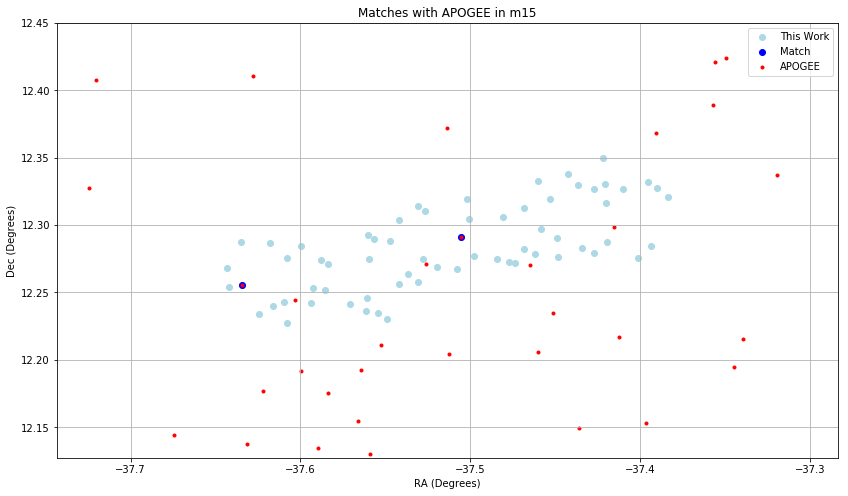



APOGEE SUMMARY: m71
1 Matches found
Index: 197178
Object: #006.0000191
DEIMOS Index: 7
DEIMOS Star Coordinate
RA: -61.620792 deg
Dec: 18.559000 deg
APOGEE Star Coordinate
RA: -61.620860 deg
Dec: 18.559000 deg
Teff = 4295.2 K
Logg = 2.30
[Fe/H] = -0.06
[Mg/H] = 0.06



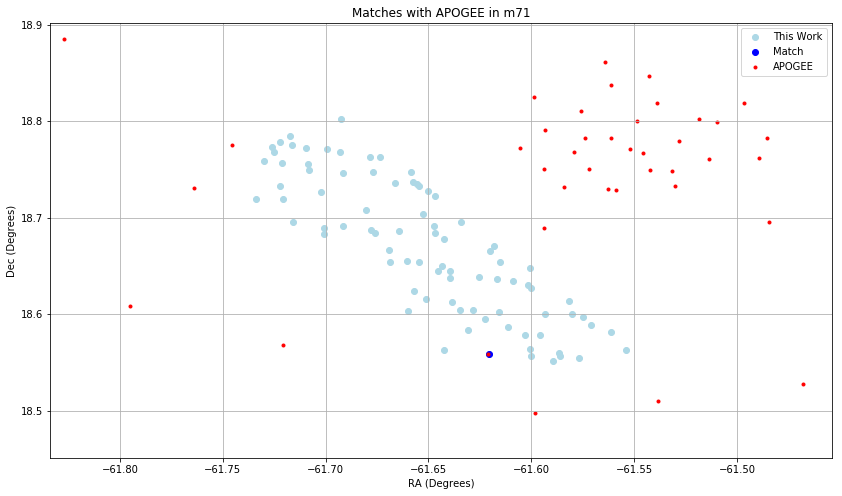



APOGEE SUMMARY: ngc2419
No Matches :(


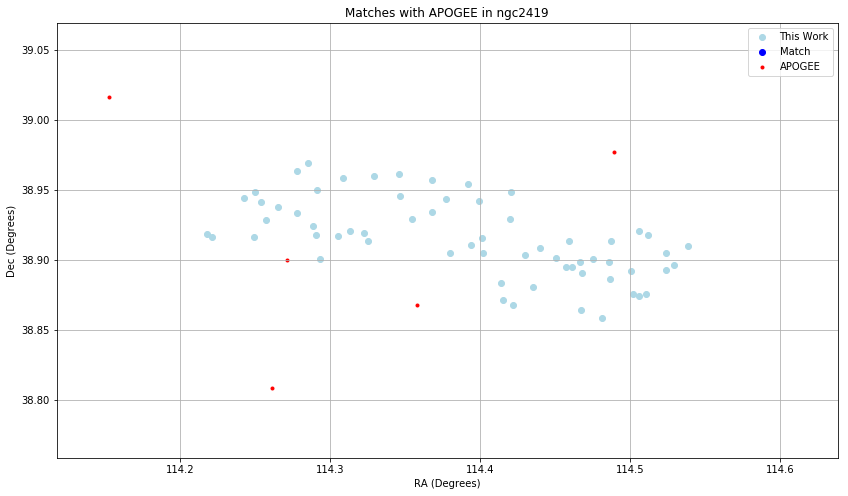



APOGEE SUMMARY: ngc7006
No Matches :(


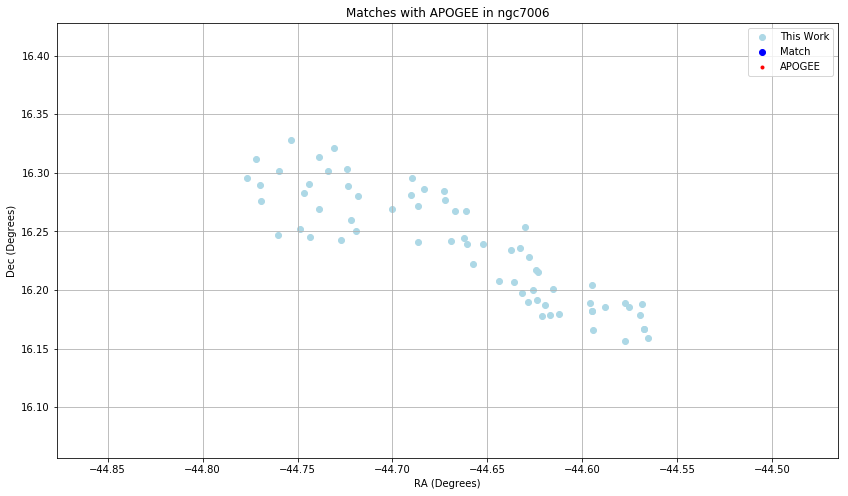



APOGEE SUMMARY: pegdig
No Matches :(


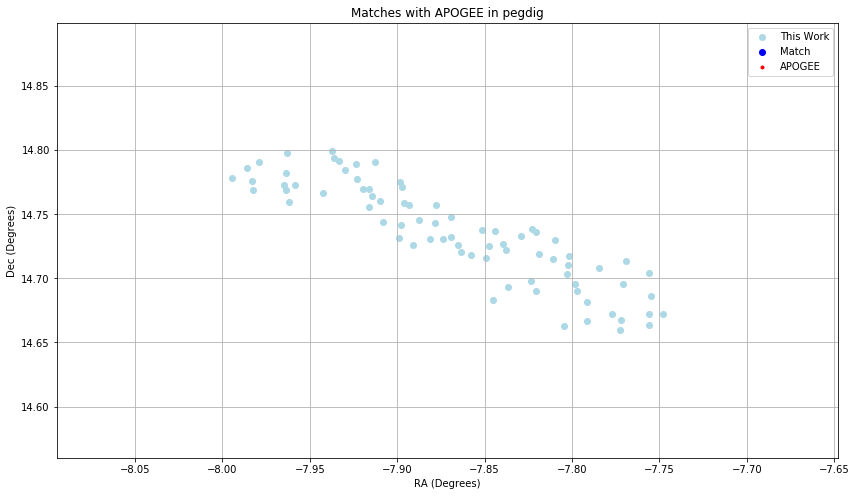



APOGEE SUMMARY: pegdig24
No Matches :(


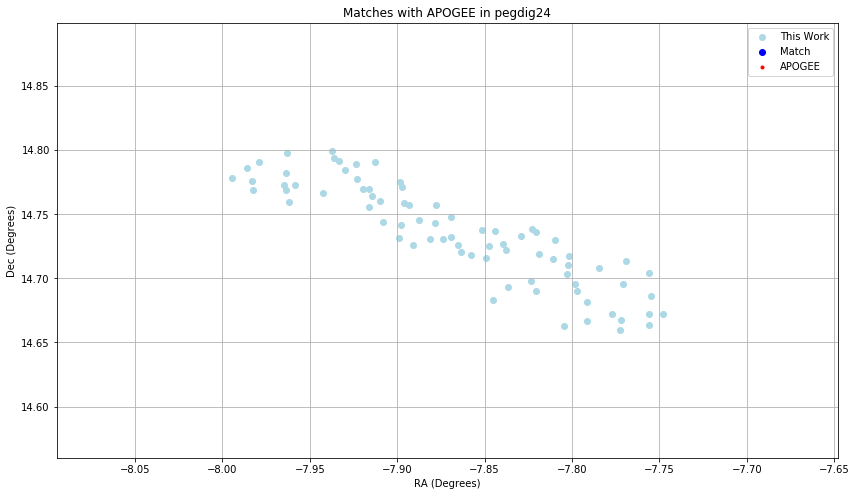



APOGEE SUMMARY: pegdig26
No Matches :(


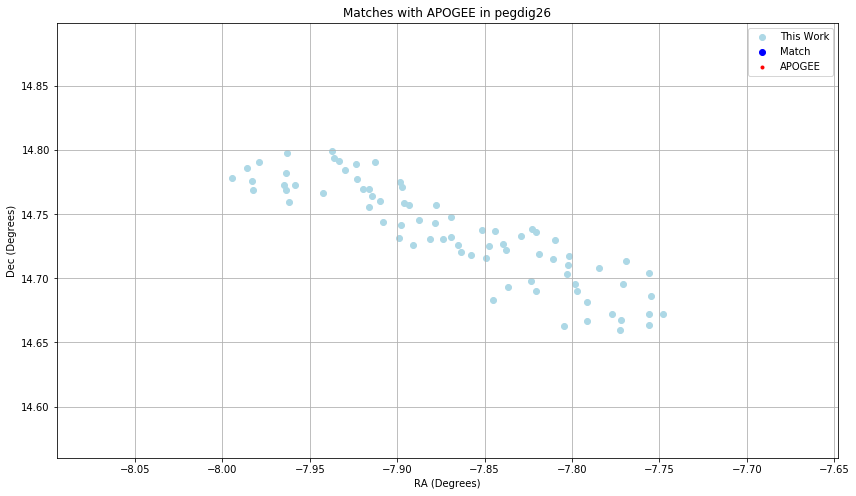

In [51]:
for target in targets:
    # Restore Observed Spectra
    obj, norm_spec, spectral_err, dv, Obs_RA_Dec = restore_observed_spectra(target, method)
        
    DEIMOS_ind = []
    APOGEE_ind = []
        
    for i in range(len(Obs_RA_Dec)):
        coord = Obs_RA_Dec[i]
        if any(char.isalpha() for char in obj[i]):
            if verbose:
                print('Skipping Serendip')
                print('')
            continue
        if verbose:
            print('Object #%s' % obj[i][4:])
            print('RA: %f' % coord.ra.deg)
            print('Dec: %f' % coord.dec.deg)
        try:
            match_ind, match_sep = find_obj_in_sample(Obj_RA_Dec=coord,
                                                     Sample_RA_Dec=APOGEE_RA_Dec,
                                                     verbose=verbose)
            APOGEE_ind.append(match_ind)
            if verbose:
                print('APOGEE ID: %i' % APOGEE_ID[match_ind])
                print('APOGEE Quality: %s' % Quality[match_ind])
                print('Separated by %.2e degrees' % match_sep)
                print('')
            DEIMOS_ind.append(i)
        except ValueError:
            if verbose:
                print('')
    
    print('\n\nAPOGEE SUMMARY: %s' % target)
    if len(APOGEE_ind)==0:
        print('No Matches :(')
    else:
        print('%i Matches found' % len(APOGEE_ind))
    for i in range(len(APOGEE_ind)):
        print('Index: %i' % APOGEE_ind[i])
        print('Object: #%s' % obj[DEIMOS_ind[i]])
        print('DEIMOS Index: %i' % DEIMOS_ind[i])
        print('DEIMOS Star Coordinate')
        print('RA: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].ra.wrap_at(180 * u.deg).deg)
        print('Dec: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].dec.wrap_at(180 * u.deg).deg)
        print('APOGEE Star Coordinate')
        print('RA: %f deg' % APOGEE_RA_Dec[APOGEE_ind[i]].ra.wrap_at(180 * u.deg).deg)
        print('Dec: %f deg' % APOGEE_RA_Dec[APOGEE_ind[i]].dec.wrap_at(180 * u.deg).deg)
        print('Teff = %s K' % APOGEE_Teff[APOGEE_ind[i]])
        print('Logg = %s' % APOGEE_logg[APOGEE_ind[i]])
        print('[Fe/H] = %s' % APOGEE_FeH[APOGEE_ind[i]])
        print('[Mg/H] = %s\n' % APOGEE_MgH[APOGEE_ind[i]])

    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)
    
    apogee_ra = APOGEE_RA_Dec.ra.wrap_at(180 * u.deg).deg
    
    obs_ra  = Obs_RA_Dec.ra.wrap_at(180 * u.deg).deg
    min_ra, max_ra = [np.min(obs_ra[np.abs(obs_ra) > 0.001]),np.max(obs_ra[np.abs(obs_ra) > 0.001])]
    min_dec, max_dec = [np.min(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001]),
                        np.max(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001])]
    
    ax.scatter(obs_ra, Obs_RA_Dec.dec.deg, marker='o',c='lightblue', label='This Work')
    ax.scatter(obs_ra[DEIMOS_ind], Obs_RA_Dec.dec.deg[DEIMOS_ind], marker='o',c='blue', label='Match')
    ax.scatter(apogee_ra, APOGEE_RA_Dec.dec.deg, marker='.',c='r', label='APOGEE')
    
    plt.grid(True)
    plt.xlim(min_ra - 0.1, max_ra + 0.1)
    plt.ylim(min_dec - 0.1, max_dec + 0.1)
    plt.xlabel('RA (Degrees)')
    plt.ylabel('Dec (Degrees)')
    plt.title('Matches with APOGEE in %s' % target)
    plt.legend()
    plt.show()

# Check Kirby 2008 GC's



Kirby SUMMARY: m13
1 Matches found
Index: 40
Object: #023.0016882
DEIMOS Index: 40
DEIMOS Star Coordinate
RA: -109.585833 deg
Dec: 36.419528 deg
kirby 2008+ Star Coordinate
RA: -109.585833 deg
Dec: 36.419444 deg
Teff = 5247 K
Logg = 3.14
[Fe/H]_M = -1.67
[alpha/H]_M = 0.18
[Fe/H]_H = 0.0
[alpha/H]_H = 0.0



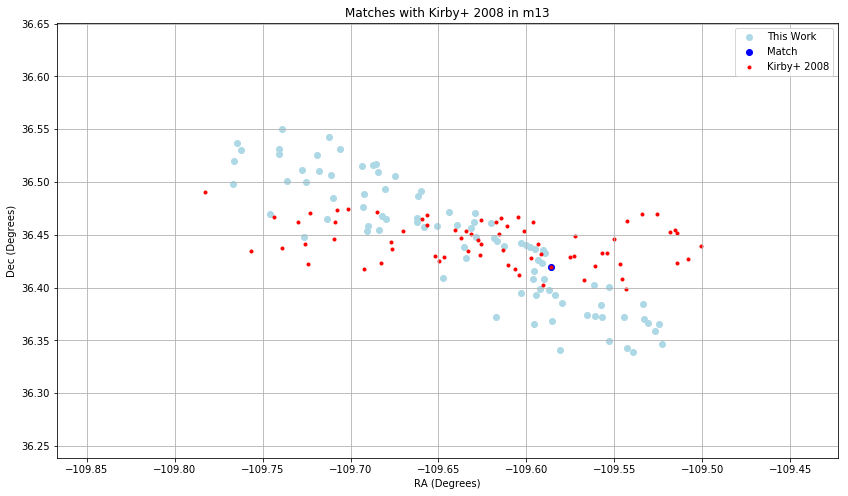



Kirby SUMMARY: m15
No Matches :(


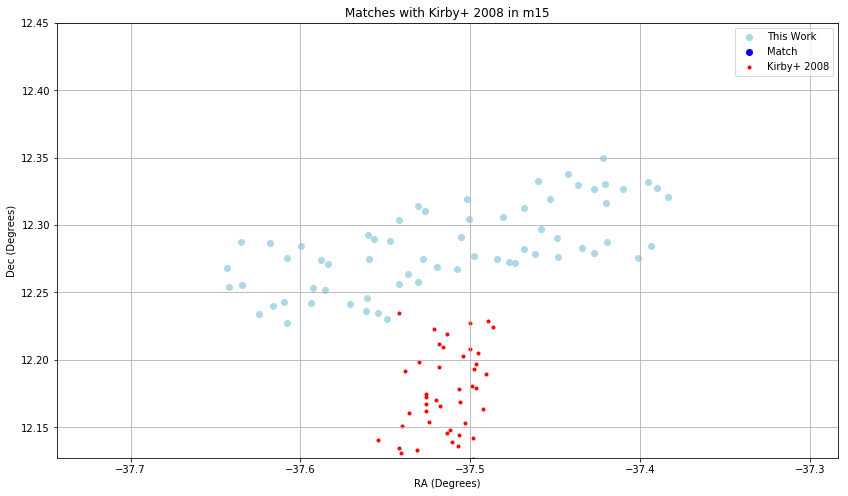



Kirby SUMMARY: m71
No Matches :(


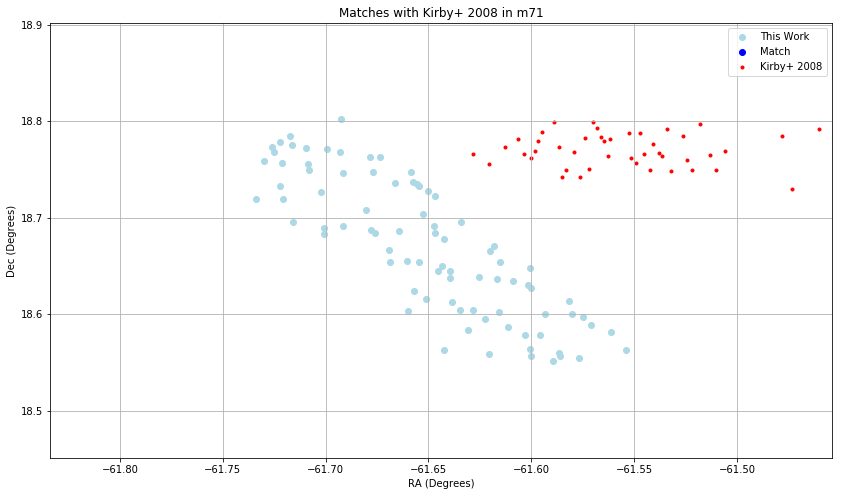



Kirby SUMMARY: ngc2419
No Matches :(


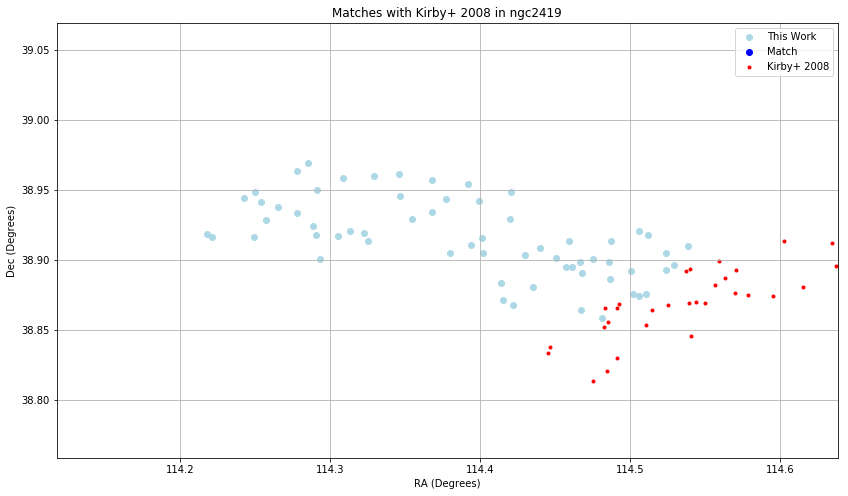



Kirby SUMMARY: ngc7006
1 Matches found
Index: 11
Object: #011.0011329
DEIMOS Index: 11
DEIMOS Star Coordinate
RA: -44.619458 deg
Dec: 16.187111 deg
kirby 2008+ Star Coordinate
RA: -44.619583 deg
Dec: 16.186944 deg
Teff = 4285 K
Logg = 0.83
[Fe/H]_M = -1.6
[alpha/H]_M = 0.47
[Fe/H]_H = 0.0
[alpha/H]_H = 0.0



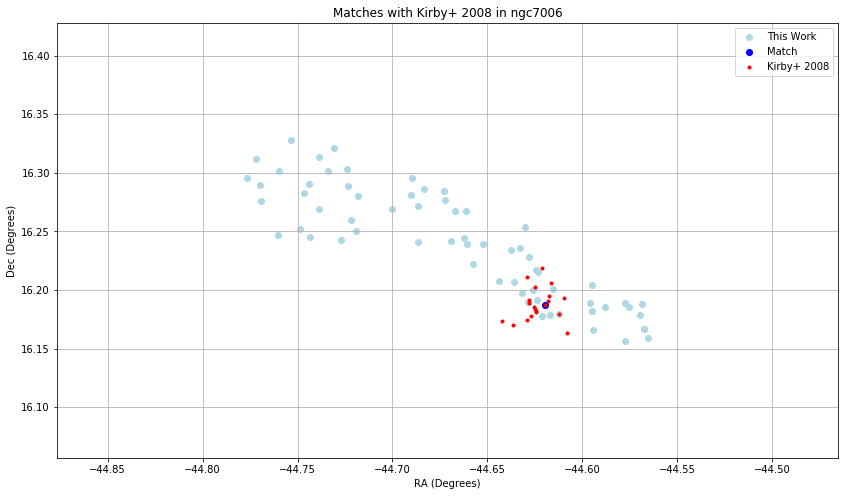



Kirby SUMMARY: pegdig
No Matches :(


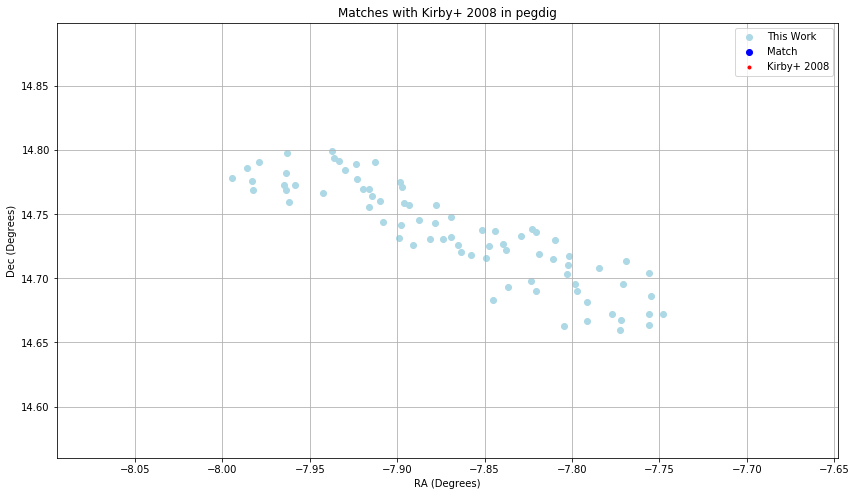



Kirby SUMMARY: pegdig24
No Matches :(


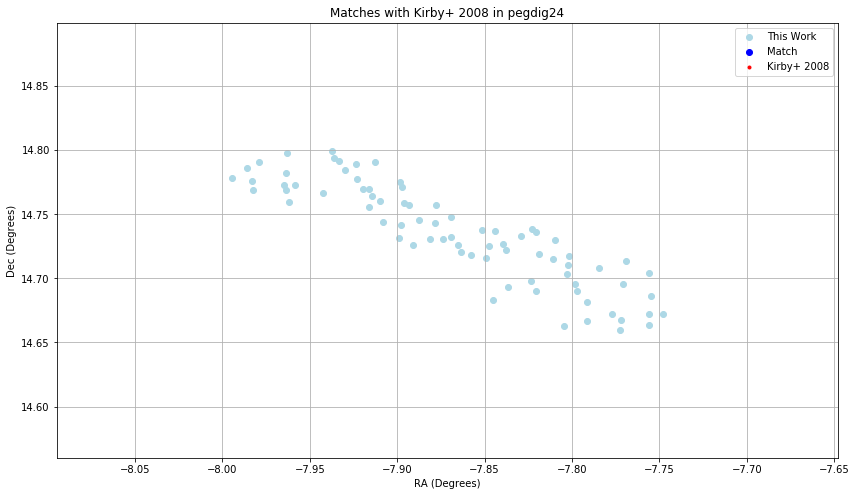



Kirby SUMMARY: pegdig26
No Matches :(


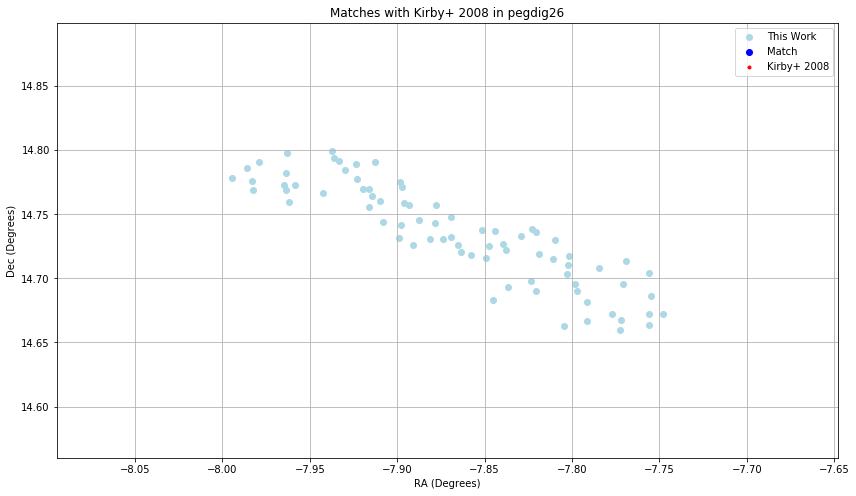

In [52]:
for target in targets:
    # Restore observed spectra
    obj, norm_spec, spectral_err, dv, Obs_RA_Dec = restore_observed_spectra(target, method)
    
    DEIMOS_ind = []
    kirby_ind = []
        
    for i in range(len(Obs_RA_Dec)):
        coord = Obs_RA_Dec[i]
        if any(char.isalpha() for char in obj[i]):
            if verbose:
                print('Skipping Serendip')
                print('')
            continue
        if verbose:
            print('Object #%s' % obj[i][4:])
            print('RA: %f' % coord.ra.deg)
            print('Dec: %f' % coord.dec.deg)
        try:
            match_ind, match_sep = find_obj_in_sample(Obj_RA_Dec=coord,
                                                     Sample_RA_Dec=kirby_RA_Dec,
                                                     verbose=verbose)
            kirby_ind.append(match_ind)
            if verbose:
                print('Name: %i' % Name[match_ind])
                print('Separated by %.2e degrees' % match_sep)
                print('')
            DEIMOS_ind.append(i)
        except ValueError:
            if verbose:
                print('')
    
    print('\n\nKirby SUMMARY: %s' % target)
    if len(kirby_ind)==0:
        print('No Matches :(')
    else:
        print('%i Matches found' % len(kirby_ind))
        for i in range(len(kirby_ind)):
            print('Index: %i' % DEIMOS_ind[i])
            print('Object: #%s' % obj[DEIMOS_ind[i]])
            print('DEIMOS Index: %i' % DEIMOS_ind[i])
            print('DEIMOS Star Coordinate')
            print('RA: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].ra.wrap_at(180 * u.deg).deg)
            print('Dec: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].dec.wrap_at(180 * u.deg).deg)
            print('kirby 2008+ Star Coordinate')
            print('RA: %f deg' % kirby_RA_Dec[kirby_ind[i]].ra.wrap_at(180 * u.deg).deg)
            print('Dec: %f deg' % kirby_RA_Dec[kirby_ind[i]].dec.wrap_at(180 * u.deg).deg)
            print('Teff = %s K' % kirby_Teff[kirby_ind[i]])
            print('Logg = %s' % kirby_logg[kirby_ind[i]])
            print('[Fe/H]_M = %s' % kirby_FeH_M[kirby_ind[i]])
            print('[alpha/H]_M = %s' % kirby_alphaFe_M[kirby_ind[i]])
            print('[Fe/H]_H = %s' % kirby_FeH_H[kirby_ind[i]])
            print('[alpha/H]_H = %s\n' % kirby_alphaFe_H[kirby_ind[i]])
            
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)
    
    kirby_ra = kirby_RA_Dec.ra.wrap_at(180 * u.deg).deg
    
    obs_ra  = Obs_RA_Dec.ra.wrap_at(180 * u.deg).deg
    min_ra, max_ra = [np.min(obs_ra[np.abs(obs_ra) > 0.001]),np.max(obs_ra[np.abs(obs_ra) > 0.001])]
    min_dec, max_dec = [np.min(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001]),
                        np.max(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001])]
    
    ax.scatter(obs_ra, Obs_RA_Dec.dec.deg, marker='o',c='lightblue', label='This Work')
    ax.scatter(obs_ra[DEIMOS_ind], Obs_RA_Dec.dec.deg[DEIMOS_ind], marker='o',c='blue', label='Match')
    ax.scatter(kirby_ra, kirby_RA_Dec.dec.deg, marker='.',c='r', label='Kirby+ 2008')
    
    plt.grid(True)
    plt.xlim(min_ra - 0.1, max_ra + 0.1)
    plt.ylim(min_dec - 0.1, max_dec + 0.1)
    plt.xlabel('RA (Degrees)')
    plt.ylabel('Dec (Degrees)')
    plt.title('Matches with Kirby+ 2008 in %s' % target)
    plt.legend()
    plt.show()